In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys
sys.path.insert(0, "python")
from network import *
from protocols import *
from adversary import *
from simulator import *

In [3]:
ew_generator = EdgeWeightGenerator("normal")

# Dandelion example

In [4]:
net = Network(100, 10, edge_weight_gen=ew_generator)

In [5]:
dp = DandelionProtocol(net, 0.5)

dp = DandelionPlusPlusProtocol(net, 0.5)

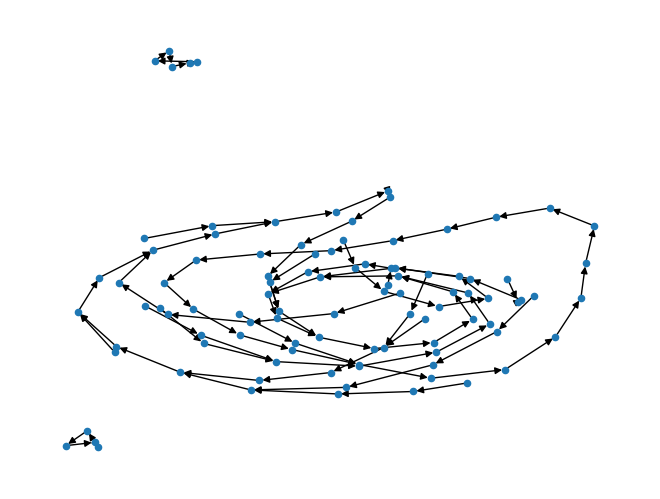

In [6]:
nx.draw(dp.anonymity_graph, node_size=20)

In [7]:
%%time
adv = Adversary(net, 0.1)
sim = Simulator(dp, adv, 10, verbose=False)
sim.run(coverage_threshold=0.95)

CPU times: user 142 ms, sys: 5.5 ms, total: 148 ms
Wall time: 165 ms


In [8]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

{'estimator': 'first_reach', 'hit_ratio': 0.2, 'inverse_rank': 0.23105572220245058, 'entropy': 0.0, 'ndcg': 0.35495812749343286, 'message_spread_ratio': 0.859}
CPU times: user 14.5 ms, sys: 2.99 ms, total: 17.5 ms
Wall time: 12.6 ms


In [9]:
%%time
evaluator = Evaluator(sim, "first_sent")
print(evaluator.get_report())

{'estimator': 'first_sent', 'hit_ratio': 0.3, 'inverse_rank': 0.32960917242869486, 'entropy': 0.0, 'ndcg': 0.4386480711785993, 'message_spread_ratio': 0.859}
CPU times: user 8.14 ms, sys: 110 µs, total: 8.25 ms
Wall time: 7.28 ms


In [10]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

{'estimator': 'dummy', 'hit_ratio': 0.0, 'inverse_rank': 0.04162238393477567, 'entropy': 4.499809670330267, 'ndcg': 0.19771041425065716, 'message_spread_ratio': 0.859}
CPU times: user 12.6 ms, sys: 599 µs, total: 13.2 ms
Wall time: 11.6 ms


# Experiment example

In [11]:
network_size = 1000
num_msg = 30
degree = 50
num_trials = 10
bc_mode = "sqrt"
adversary_ratios = [0.01,0.05,0.1]

In [12]:
from tqdm.notebook import tqdm

### Messages are propagated until full coverage

In [13]:
def run_and_eval(net: Network, adv: Adversary, protocol: Protocol):
    sim = Simulator(protocol, adv, num_msg, verbose=False)
    sim.run(coverage_threshold=1.0)
    reports = []
    for estimator in ["first_reach","first_sent"]:
        evaluator = Evaluator(sim, estimator)
        report = evaluator.get_report()
        report["protocol"] = str(protocol)
        report["adversary_ratio"] = adv.ratio
        reports.append(report)
    return reports, sim

In [14]:
def run_experiment(adversary_ratios, is_active_adversary=False):
    results = []
    # it could be parallelized
    for adv_ratio in adversary_ratios:
        for _ in tqdm(range(num_trials)):
            # this part cannot be parallelized: it is important that different protocols will be evaluated with the same network and adversary setting
            net = Network(network_size, degree, edge_weight_gen=ew_generator)
            adv = Adversary(net, adv_ratio, is_active_adversary)
            protocols = [
                BroadcastProtocol(net, broadcast_mode=bc_mode),
                DandelionProtocol(net, 0.5, broadcast_mode=bc_mode),
                DandelionProtocol(net, 0.25, broadcast_mode=bc_mode),
                DandelionPlusPlusProtocol(net, 0.5, broadcast_mode=bc_mode),
                DandelionPlusPlusProtocol(net, 0.25, broadcast_mode=bc_mode),
            ]
            for protocol in protocols:
                new_reports, sim = run_and_eval(net, adv, protocol)
                results += new_reports
        print(adv_ratio)
    results_df = pd.DataFrame(results)
    return results_df

In [15]:
%%time
results_df = run_experiment(adversary_ratios)

  0%|          | 0/10 [00:00<?, ?it/s]

0.01


  0%|          | 0/10 [00:00<?, ?it/s]

0.05


  0%|          | 0/10 [00:00<?, ?it/s]

0.1
CPU times: user 18min 30s, sys: 6.74 s, total: 18min 37s
Wall time: 18min 21s


In [16]:
def shorten_protocol_names(df, col="protocol"):
    def transform_protocol_names(x: str):
        val = x.replace("Protocol","").replace("spreading_proba","p")
        val = val.split("broadcast")[0][:-1].replace("(", ": ")
        if val[-1] == ",":
            val = val[:-1]
        return val
    tmp_df = df.copy()
    tmp_df[col] = tmp_df[col].apply(transform_protocol_names)
    return tmp_df

In [17]:
results_df_short = shorten_protocol_names(results_df)

In [18]:
fr_results_df = results_df_short[results_df_short["estimator"]=="first_reach"]
fs_results_df = results_df_short[results_df_short["estimator"]=="first_sent"]
print(fr_results_df.shape, fs_results_df.shape)

(150, 8) (150, 8)


## a.) Adversary performance

- First-sent estimator performs better than first reach - **OK**

In [19]:
fr_results_df_short = shorten_protocol_names(fr_results_df)
fs_results_df_short = shorten_protocol_names(fs_results_df)

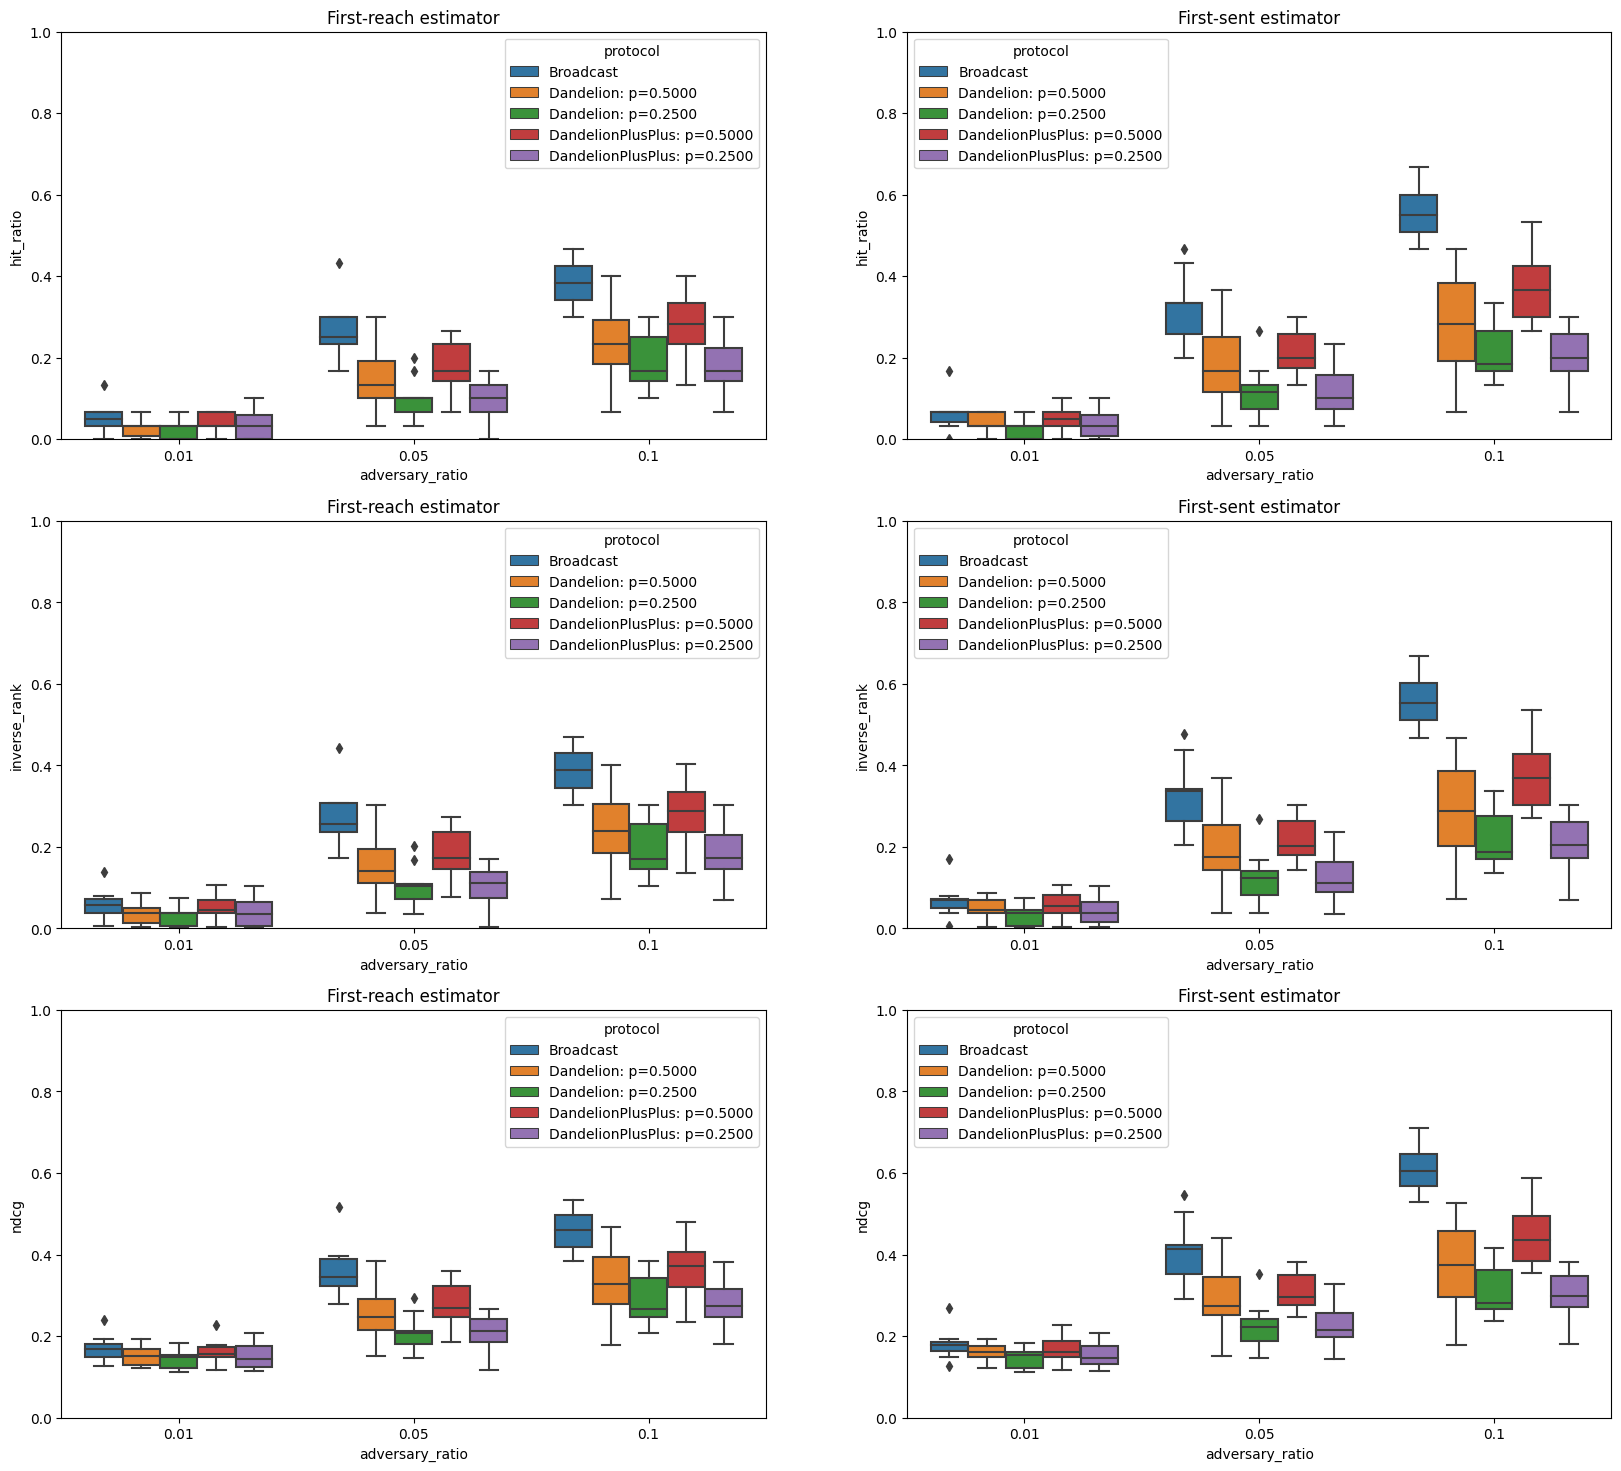

In [20]:
fig, ax = plt.subplots(3,2, figsize=(20,18))
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][0])
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[1][0])
sns.boxplot(data=fr_results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[2][0])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="hit_ratio", hue="protocol", ax=ax[0][1])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="inverse_rank", hue="protocol", ax=ax[1][1])
sns.boxplot(data=fs_results_df, x="adversary_ratio", y="ndcg", hue="protocol", ax=ax[2][1])
for i in range(3):
    for j in range(2):
        ax[i][j].set_title("First-reach estimator" if j % 2 == 0 else "First-sent estimator")
        ax[i][j].set_ylim(0,1.0)

While the fraction of nodes reached by messages are the same range for all protocols

<AxesSubplot: xlabel='adversary_ratio', ylabel='message_spread_ratio'>

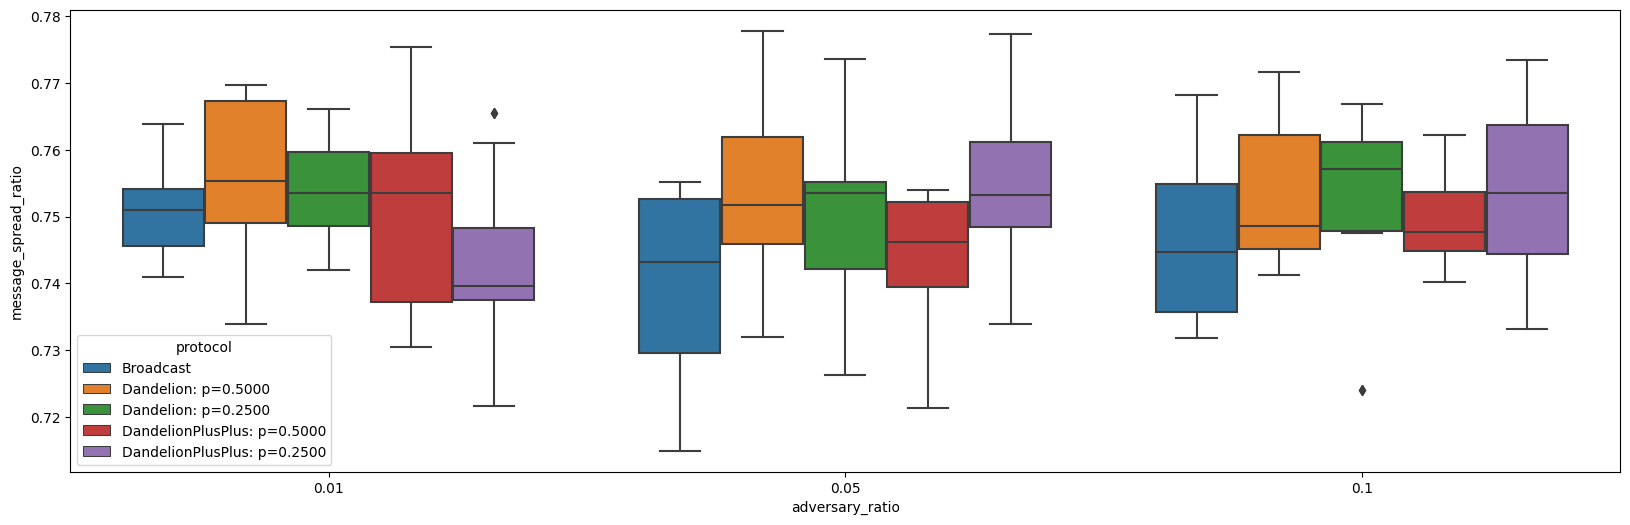

In [21]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.boxplot(data=results_df_short, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax)

## b.) Passive vs. active adversary

**active adversary:** simply does not forward the received message

**passive adversary:** forwards every message according to protocol rules

In [22]:
%%time
active_results_df = run_experiment(adversary_ratios, True)
active_results_df = active_results_df[active_results_df["estimator"]=="first_sent"]
active_results_df.shape

  0%|          | 0/10 [00:00<?, ?it/s]

0.01


  0%|          | 0/10 [00:00<?, ?it/s]

0.05


  0%|          | 0/10 [00:00<?, ?it/s]

0.1
CPU times: user 16min 33s, sys: 6.16 s, total: 16min 39s
Wall time: 16min 26s


(150, 8)

In [23]:
active_results_df_short = shorten_protocol_names(active_results_df)

The results show that **longer stem-phase in the Dandelion protocol** (low broadcast probability) **have a negative impact on the message spread ratio** (ratio of all nodes who receives the message) - as expected.

(0.4, 0.8)

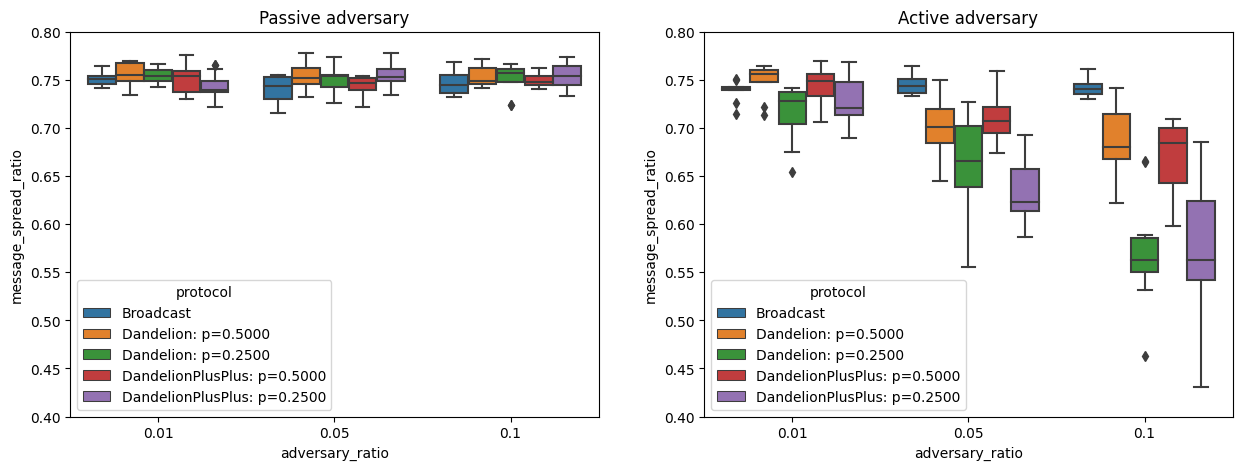

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=results_df_short, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax[0])
ax[0].set_title("Passive adversary")
ax[0].set_ylim(0.4,0.8)
sns.boxplot(data=active_results_df_short, x="adversary_ratio", y="message_spread_ratio", hue="protocol", ax=ax[1])
ax[1].set_title("Active adversary")
ax[1].set_ylim(0.4,0.8)